In [30]:
from v4vapp_backend_v2.database.db import MongoDBClient
from v4vapp_backend_v2.config.setup import InternalConfig
from pymongo import AsyncMongoClient
import os
import pandas as pd
import matplotlib.pyplot as plt


print("Current working directory:", os.getcwd())


project_root = "/Users/bol/Documents/dev/v4vapp/v4vapp-backend-v2"
if os.getcwd() != project_root:
    os.chdir(project_root)
print("Current working directory:", os.getcwd())

CONFIG = InternalConfig(config_filename="devhive.config.yaml").config

old_client = MongoDBClient(
    db_conn=CONFIG.dbs_config.default_connection,
    db_name=CONFIG.dbs_config.default_name,
    db_user=CONFIG.dbs_config.default_user,
)

client = AsyncMongoClient(old_client.uri, tz_aware=True)
db = client[CONFIG.dbs_config.default_name]
rates_collection = db["rates"]


2025-05-25T11:58:31+0300.963 INFO     db                        160 : 📁 backend Initializing MongoDBClient local_connection


Current working directory: /Users/bol/Documents/dev/v4vapp/v4vapp-backend-v2
Current working directory: /Users/bol/Documents/dev/v4vapp/v4vapp-backend-v2


In [31]:
old_rates = db["old_hive_rates_single"]
await old_rates.distinct("pair")

['btc_usd', 'hive_hbd', 'hive_usd', 'sats_hive']

In [37]:
import pandas as pd
import numpy as np

# Load all old rates into a DataFrame
cursor = old_rates.find({}, sort=[("timestamp", 1)])
docs = await cursor.to_list(length=None)
df = pd.DataFrame(docs)

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Pivot so each row is a timestamp, columns are pairs
pivot = df.pivot_table(index="timestamp", columns="pair", values="value", aggfunc="first")

# Resample to at most one entry per 10 minutes (take the first in each 10-min window)
pivot = pivot.resample("10T").first().dropna(how="all")
pivot = pivot.reset_index()

# Fill in missing fields and calculate as needed
if "hbd_usd" in pivot.columns:
    pivot["hbd_usd"] = pivot["hbd_usd"].fillna(1.0)
else:
    pivot["hbd_usd"] = 1.0

if "btc_usd" not in pivot.columns:
    pivot["btc_usd"] = np.nan
if "hbd_usd" not in pivot.columns:
    pivot["hbd_usd"] = 1.0

if "hive_hbd" not in pivot.columns:
    pivot["hive_hbd"] = np.nan
if "hive_usd" not in pivot.columns:
    pivot["hive_usd"] = np.nan

if "sats_hive" not in pivot.columns:
    pivot["sats_hive"] = np.nan

# Calculate missing hive_hbd or hive_usd if possible
mask = pivot["hive_hbd"].isna() & pivot["hive_usd"].notna()
pivot.loc[mask, "hive_hbd"] = pivot.loc[mask, "hive_usd"] / pivot.loc[mask, "hbd_usd"]

mask = pivot["hive_usd"].isna() & pivot["hive_hbd"].notna()
pivot.loc[mask, "hive_usd"] = pivot.loc[mask, "hive_hbd"] * pivot.loc[mask, "hbd_usd"]

# Calculate sats_usd and sats_hbd based on btc_usd and hbd_usd
pivot["sats_usd"] = 100_000_000 / pivot["btc_usd"]
pivot["sats_hbd"] = pivot["sats_usd"] * pivot["hbd_usd"]

# Round to match the desired precision
rounding = {
    "hive_usd": 4,
    "sats_hbd": 4,
    "sats_hive": 4,
    "hbd_usd": 0,
    "hive_hbd": 4,
    "btc_usd": 2,
    "sats_usd": 4,
}

for col, ndigits in rounding.items():
    if col in pivot.columns:
        if ndigits == 0:
            pivot[col] = pivot[col].round(0).astype("Int64")
        else:
            pivot[col] = pivot[col].round(ndigits)

# Prepare the output dictionaries (without _id, timestamp as UTC datetime)
fields = [
    "timestamp",
    "hive_usd",
    "sats_hbd",
    "sats_hive",
    "hbd_usd",
    "hive_hbd",
    "btc_usd",
    "sats_usd",
]
records = []
for _, row in pivot.iterrows():
    record = {field: row.get(field, None) for field in fields}
    # Ensure timestamp is a timezone-aware UTC datetime
    if pd.notnull(row["timestamp"]):
        ts = row["timestamp"]
        if ts.tzinfo is None:
            ts = ts.tz_localize("UTC")
        else:
            ts = ts.tz_convert("UTC")
        record["timestamp"] = ts
    else:
        record["timestamp"] = None
    records.append(record)

# Example: print the first combined record
print(records[0])
print(f"Total combined records: {len(records)}")


{'timestamp': Timestamp('2025-04-20 19:30:00+0000', tz='UTC'), 'hive_usd': 0.2359, 'sats_hbd': 1182.3551, 'sats_hive': 278.9176, 'hbd_usd': 1, 'hive_hbd': 0.2362, 'btc_usd': 84576.96, 'sats_usd': 1182.3551}
Total combined records: 1003


In [40]:
for record in records:
    print(record)
    # ans = await rates_collection.insert_one(record)
    # print(ans)


{'timestamp': Timestamp('2025-04-20 19:30:00+0000', tz='UTC'), 'hive_usd': 0.2359, 'sats_hbd': 1182.3551, 'sats_hive': 278.9176, 'hbd_usd': 1, 'hive_hbd': 0.2362, 'btc_usd': 84576.96, 'sats_usd': 1182.3551, '_id': ObjectId('6832de4c7893f09545a255eb')}
{'timestamp': Timestamp('2025-04-20 21:40:00+0000', tz='UTC'), 'hive_usd': 0.2373, 'sats_hbd': 1175.5382, 'sats_hive': 278.9552, 'hbd_usd': 1, 'hive_hbd': 0.2374, 'btc_usd': 85067.42, 'sats_usd': 1175.5382, '_id': ObjectId('6832de4c7893f09545a255ec')}
{'timestamp': Timestamp('2025-04-20 21:50:00+0000', tz='UTC'), 'hive_usd': 0.237, 'sats_hbd': 1175.6668, 'sats_hive': 278.633, 'hbd_usd': 1, 'hive_hbd': 0.2375, 'btc_usd': 85058.11, 'sats_usd': 1175.6668, '_id': ObjectId('6832de4c7893f09545a255ed')}
{'timestamp': Timestamp('2025-04-20 22:00:00+0000', tz='UTC'), 'hive_usd': 0.2369, 'sats_hbd': 1177.6566, 'sats_hive': 278.9868, 'hbd_usd': 1, 'hive_hbd': 0.2374, 'btc_usd': 84914.4, 'sats_usd': 1177.6566, '_id': ObjectId('6832de4c7893f09545a255e

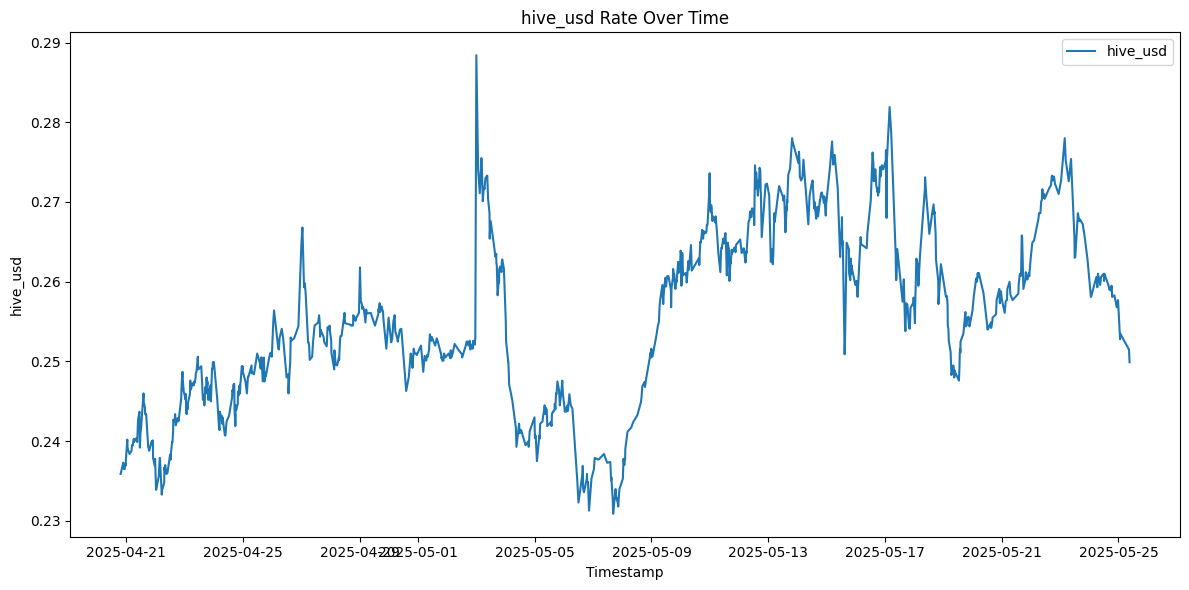

In [43]:
# Query all records from rates_collection and load into a DataFrame
cursor = rates_collection.find({}, {"timestamp": 1, "hive_usd": 1, "_id": 0})
docs = await cursor.to_list(length=None)
df_hive_usd = pd.DataFrame(docs)

# Ensure timestamp is datetime and sort
df_hive_usd["timestamp"] = pd.to_datetime(df_hive_usd["timestamp"])
df_hive_usd = df_hive_usd.sort_values("timestamp")

# Plot hive_usd over time
plt.figure(figsize=(12, 6))
plt.plot(df_hive_usd["timestamp"], df_hive_usd["hive_usd"], label="hive_usd")
plt.xlabel("Timestamp")
plt.ylabel("hive_usd")
plt.title("hive_usd Rate Over Time")
plt.legend()
plt.tight_layout()
plt.show()